<a href="https://colab.research.google.com/github/coldbilberry/repo-gui/blob/main/%D0%A3%D1%80%D0%BE%D0%BA_10_%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BB%D0%B8%D1%86_%D0%B8_%D1%8D%D0%BC%D0%BE%D1%86%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install facenet-pytorch==2.5.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

from glob import glob
import sys, os

import PIL
from PIL import Image
import cv2

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.utils import make_grid


from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tqdm import tqdm

from facenet_pytorch import MTCNN

In [3]:
from google.colab import drive
drive.mount('/content/drive')

images = glob('/content/drive/MyDrive/leapGestRecog/leapGestRecog/**/**/*.png')

Mounted at /content/drive


In [4]:
labels = [int(os.path.basename(img).split('_')[2])-1 for img in images] # отнимаем 1, чтобы были классы с 0

images[:5], labels[:5]

([], [])

In [5]:
len(images)

0

In [6]:
class_nums_names = [(int((os.path.split(img)[0].split('/')[-1].split('_'))[0])-1, os.path.split(img)[0].split('/')[-1].split('_')[1:]) for img in images]
nums_names_classes = {}
for num, name in class_nums_names:
    if num not in nums_names_classes.keys():
        nums_names_classes[num] = name

sorted(nums_names_classes.items(), key = lambda x: x[0])

[]

In [7]:
def num_to_classname(num):
    if num == 0:
        return 'palm'
    elif num == 1:
        return 'l'
    elif num == 2:
        return 'fist'
    elif num == 3:
        return 'fist_moved'
    elif num == 4:
        return 'thumb'
    elif num == 5:
        return 'index'
    elif num == 6:
        return 'ok'
    elif num == 7:
        return 'palm_moved'
    elif num == 8:
        return 'c'
    elif num == 9:
        return 'down'

In [ ]:
# Train test split

test_size = 0.3
random_state = 1

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=test_size, random_state=random_state)

In [ ]:
img = Image.open(images[3])
print(np.array(img).shape)
img

In [10]:
# Transform train & test data

train_transformer = transforms.Compose([
                         transforms.Grayscale(num_output_channels=1),
                         transforms.Resize((48,48)),
                         transforms.RandomHorizontalFlip(),
                         transforms.RandomRotation(30),
                         transforms.ToTensor()])

val_transformer =  transforms.Compose([
                         transforms.Grayscale(num_output_channels=1),
                         transforms.Resize((48,48)),
                         transforms.ToTensor()])

In [11]:
class GestureDataset(Dataset):
    def __init__(self, images_gestures, labels, transformer):
        self.images = images_gestures
        self.labels = labels
        self.transformer = transformer

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img =  Image.open(self.images[idx])
        img = self.transformer(img)

        return img, self.labels[idx]

In [ ]:
batch_size = 256

# Create datasets
train_dataset = GestureDataset(X_train, y_train, train_transformer)
val_dataset = GestureDataset(X_val, y_val, val_transformer)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size, shuffle = True, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size, shuffle = False)

In [ ]:
for i, data in enumerate(train_loader):
    print(f'Класс: {data[1][i]} - {num_to_classname(data[1][i])}')
    print(data[0][i].shape)
    plt.imshow(data[0][i].permute(1,2,0).squeeze())
    plt.show()
    if i>5:
        break

In [ ]:
def show_batch(train_loader):

    for images, labels in train_loader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(f'image: {images[0].shape}')
        ax.imshow(make_grid(images[:16], nrow=4).permute(1, 2, 0))
        break

show_batch(train_loader)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [16]:
# Class ResNet

def conv_block(in_channels, out_channels, pool=False):

    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))

    return nn.Sequential(*layers)

def linear_block(input_dim, output_dim, activation = False, dropout = 0.3):

    layers = [nn.Linear(input_dim, output_dim),
             nn.Dropout(dropout)]
    if activation:
        layers.append(nn.ReLU())

    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)

        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)

        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)

        self.classifier = nn.Sequential(nn.MaxPool2d(6),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)

        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)

        out = self.classifier(out)
        return out

In [17]:
# Initialize & compile the model

net = ResNet(1, len(nums_names_classes)).to(device)

learning_rate = 0.01
optimizer = torch.optim.Adam(net.parameters(), learning_rate)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [ ]:
for i, (img, label) in enumerate(train_loader):
    output = net(img[i][None].to(device))
    print(f'Real gesture: {int(label[i]), num_to_classname(int(label[i]))}, '
          f'Predicted gesture: {int(output.argmax(1)), num_to_classname(int(output.argmax(1)))}')
    plt.imshow(img[i].permute(1,2,0).squeeze())
    break

In [ ]:
# Model learning

epochs = 15

epoch_losses = []

for epoch in range(epochs):

    train_running_loss = 0.0
    total_acc_train = 0.0
    epoch_loss = []
    for data, labels in tqdm(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(data)
        loss = criterion(outputs, labels)

        train_running_loss += loss.item()
        epoch_loss.append(loss.item())

        acc = (outputs.argmax(dim=1) == labels).sum().item()
        total_acc_train += acc

        loss.backward()
        optimizer.step()


    val_running_loss, total_acc_val = 0.0, 0.0
    val_epoch_loss = []
    for data, labels in val_loader:
        net.eval()
        data = data.to(device)
        labels = labels.to(device)

        outputs = net(data)
        loss = criterion(outputs, labels)

        val_running_loss += loss.item()
        val_epoch_loss.append(loss.item())

        acc = (outputs.argmax(dim=1) == labels).sum().item()
        total_acc_val += acc

    print(f'Epoch {epoch+1}, loss:, {np.mean(epoch_loss)}, Train acc:, {total_acc_train / len(train_dataset):.3f}  '
          f'Val loss:, {np.mean(val_epoch_loss)}, Val acc: {total_acc_val / len(val_dataset):.3f}')
    epoch_losses.append(epoch_loss)

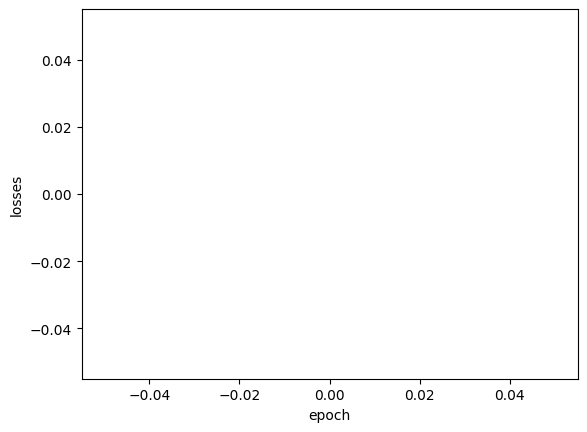

In [20]:
# Plot loss

losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses');

In [21]:
# Save model

model_path = './gesture_classification_model.pth'
torch.save(net, model_path)

In [ ]:
# Load model

net = torch.load(model_path)
with torch.no_grad():
    for i, data in enumerate(val_loader, 3):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)
        plt.title(f'pred - {num_to_classname(outputs[0].argmax())}, gt - {num_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

In [23]:
# Load libraries

import numpy as np
import pandas as pd

import PIL
from PIL import Image
import cv2

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.utils import make_grid

from facenet_pytorch import MTCNN

In [24]:
def conv_block(in_channels, out_channels, pool=False):

    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))

    return nn.Sequential(*layers)

# Блок линейных слоев
def linear_block(input_dim, output_dim, activation = False, dropout = 0.3):

    layers = [nn.Linear(input_dim, output_dim),
             nn.Dropout(dropout)]
    if activation:
        layers.append(nn.ReLU())

    return nn.Sequential(*layers)


#  Сеть
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # Конволюционная часть сети
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)

        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)

        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)


        self.max_pool = nn.MaxPool2d(6)
        self.flatten = nn.Flatten()

        self.ff1 = linear_block(512, 256, activation = True)
        self.ff2 = linear_block(256, 128, activation = True)
        self.classifier = linear_block(128, num_classes)

    def forward(self, xb):
        #Convolution layers
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out)
        out = self.drop1(out)

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)

        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)

        out = self.max_pool(out)
        out = self.flatten(out)

        # Feed Forward layers
        out = self.ff1(out)
        out = self.ff2(out)
        out = self.classifier(out)

        return out

In [25]:
gesture_clf = ResNet(1, 10)
gesture_clf = torch.load(model_path)

In [26]:
# Class FaceDetector

class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.gestmodel = torch.load(model_path, map_location=torch.device('cpu'))
        self.gestmodel.eval()

    def _draw(self, frame, boxes, landmarks, gesture):
        """
        Draw landmarks and boxes for each face detected
        """
        try:
            for box, ld in zip(boxes, landmarks):
                cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                              (255,255,0), thickness=2)

                cv2.putText(frame,
                    gesture, (int(box[2]), int(box[3])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

                cv2.circle(frame, tuple([int(i) for i in ld[0]]), 5, (255,255,0), -1)
                cv2.circle(frame, tuple([int(i) for i in ld[1]]), 5, (255,255,0), -1)
                cv2.circle(frame, tuple([int(i) for i in ld[2]]), 5, (255,255,0), -1)
                cv2.circle(frame, tuple([int(i) for i in ld[3]]), 5, (255,255,0), -1)
                cv2.circle(frame, tuple([int(i) for i in ld[4]]), 5, (255,255,0), -1)
        except:
            pass

        return frame

    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]),
                int(box[0]):int(box[2])])
        return faces

    @staticmethod
    def transform_frame(frame):
        transformer = transforms.Compose([
                      transforms.ToPILImage(),
                      transforms.Grayscale(num_output_channels=1),
                      transforms.Resize((48,48)),
                      transforms.ToTensor()])

        return transformer(frame).unsqueeze(1)

    @staticmethod
    def num_to_classname(num):
        if num == 0:
            return 'palm'
        elif num == 1:
            return 'l'
        elif num == 2:
            return 'fist'
        elif num == 3:
            return 'fist_moved'
        elif num == 4:
            return 'thumb'
        elif num == 5:
            return 'index'
        elif num == 6:
            return 'ok'
        elif num == 7:
            return 'palm_moved'
        elif num == 8:
            return 'c'
        elif num == 9:
            return 'down'


    @staticmethod
    def reactions_to_gestures(gesture):
        if gesture == 'thumb':
            plt.imshow(cv2.cvtColor(cv2.imread('./imgs reactions/good jıb.jpeg'), cv2.COLOR_BGR2RGB))
            plt.show()
            print(f"Hi! See your photo below, you're amazing today :D. Your gesture is {gesture}, am I right?")

        elif gesture == 'ok':
            plt.imshow(cv2.cvtColor(cv2.imread('./imgs reactions/ok.jpeg'), cv2.COLOR_BGR2RGB))
            plt.show()
            print(f"Hey, you're showing OK! See your photo below! :D. I think, your gesture is {gesture}, am I right?")

        elif gesture == 'palm' or gesture == 'palm_moved':
            plt.imshow(cv2.cvtColor(cv2.imread('./imgs reactions/palm.jpeg'), cv2.COLOR_BGR2RGB))
            plt.show()
            print(f"Hi! See your photo below, you're amazing today :D. Your gesture is {gesture}, am I right?")

        elif gesture == 'fist' or  gesture == 'fist_moved':
            print(f"Hey, why you angry today? :( I think, your gesture is {gesture}, am I right?")
            plt.imshow(cv2.cvtColor(cv2.imread('./imgs reactions/fist.jpeg'), cv2.COLOR_BGR2RGB))
            plt.show()

        else:
            game(15)
            print(f'Hi! I think, your gesture is {gesture}, am I right?')


    @staticmethod
    def game(turns):
        print(f"Let's play the game! Try to guess the word letter by letter!You have {turns} attempts!")

        want_to_play= input('Do you want to play? Enter Y or N: ')[0]
        want_to_play.lower()

        if want_to_play == 'y':

            wordList = ["python", "pytorch", "nets", "framework"]
            shuffle(wordList)
            word = wordList.pop()

            guesses = ""

            while turns > 0:
                wrong = 0

                for letter in word:
                    if letter in guesses:
                        print(letter, end=" ")
                    else:
                        print("_", end=" ")
                        wrong += 1

                print("\n")

                if wrong == 0:
                    print("You win!!! :)")
                    break

                guess = ""
                guess = input("Enter the ENGLISH letter and press 'enter': ")[0]
                guess.lower()
                if guess in guesses:
                    print("You had entered this letter before")
                guesses += guess

                turns -=1
                if guess not in word:
                    print(f"No letter {guess} in this word ")

                else:
                    print(f"Correct! Letter {guess} contains in our word ")


                print(f"You have {turns} attempts left")


                if turns == 0:
                    print("Sorry, you lose :(")

        if want_to_play == 'n':
            print('See you next time! Bye;)')


    def run(self):

        try:
            cap = cv2.VideoCapture(0)
            for i in range(3):
                cap.read()
            ret, frame = cap.read()

            boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)

            face = self.crop_faces(frame, boxes)[0]

            frame_for_model = self.transform_frame(frame)
            gesture = self.gestmodel(frame_for_model)
            gesture = self.num_to_classname(gesture.argmax())
            self.reactions_to_gestures(gesture)

            self._draw(frame, boxes, landmarks, gesture)

            plt.imshow(frame)
            plt.show()


        except:
            pass

        cap.release()
        cv2.destroyAllWindows()

In [27]:
# FIRST run
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn)
fcd.run()